# Import 

In [573]:
# Data structure libraries
import pandas as pd
import numpy as np

# ML libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KernelDensity

# Math libraries
from statistics import mean 

# Visualization libraries
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Load Dataset

In [667]:
sleep_data = pd.read_csv('./Data/processed_data.csv')

# Data Preprocessing

In [668]:
def normalize_feature(feature_to_normalize, max_val, min_val) :
    feature_length = len(feature_to_normalize)
    normalized = []
    for i in range(feature_length) :
        normalized.append(((feature_to_normalize[i] - min_val) / (max_val - min_val)))
    return normalized

In [669]:
# Removing unnamed column
sleep_data = sleep_data.loc[:, ~sleep_data.columns.str.contains('^Unnamed')]

In [670]:
# Removing SEQN
sleep_data = sleep_data.loc[:, ~sleep_data.columns.str.contains('SEQN')]

In [671]:
# Rearrange columns
new_cols = ['RIAGENDR', 'RIDAGEYR', 'SLQ040', 'SLQ050', 'DPQ020', 'DPQ030', 'DPQ040', 'BMXBMI',
                      'DR1IMAGN', 'DR1IIRON', 'DR1ISFAT', 'DR1IPFAT', 'DR1IMFAT', 
                      'DR2IMAGN', 'DR2IIRON', 'DR2ISFAT', 'DR2IPFAT', 'DR2IMFAT',
                      'SLD012', 'SLQ120', 'sleep_disorder']

sleep_data = sleep_data[new_cols]

# Normalize data
maxList = sleep_data.max()
minList = sleep_data.min()

# Lists that store the normalized values
RIAGENDR_norm = normalize_feature(sleep_data['RIAGENDR'].values.tolist(), maxList[0], minList[0])
RIDAGEYR_norm = normalize_feature(sleep_data['RIDAGEYR'].values.tolist(), maxList[1], minList[1])
SLQ040_norm = normalize_feature(sleep_data['SLQ040'].values.tolist(), maxList[2], minList[2])
SLQ050_norm = normalize_feature(sleep_data['SLQ050'].values.tolist(), maxList[3], minList[3])

DPQ020_norm = normalize_feature(sleep_data['DPQ020'].values.tolist(), maxList[4], minList[4])
DPQ030_norm = normalize_feature(sleep_data['DPQ030'].values.tolist(), maxList[5], minList[5])
DPQ040_norm = normalize_feature(sleep_data['DPQ040'].values.tolist(), maxList[6], minList[6])

BMXBMI_norm = normalize_feature(sleep_data['BMXBMI'].values.tolist(), maxList[7], minList[7])

DR1IMAGN_norm = normalize_feature(sleep_data['DR1IMAGN'].values.tolist(), maxList[8], minList[8])
DR1IIRON_norm = normalize_feature(sleep_data['DR1IIRON'].values.tolist(), maxList[9], minList[9])

DR1ISFAT_norm = normalize_feature(sleep_data['DR1ISFAT'].values.tolist(), maxList[10], minList[10])
DR1IPFAT_norm = normalize_feature(sleep_data['DR1IPFAT'].values.tolist(), maxList[11], minList[11])
DR1IMFAT_norm = normalize_feature(sleep_data['DR1IMFAT'].values.tolist(), maxList[12], minList[12])
DR2IMAGN_norm = normalize_feature(sleep_data['DR2IMAGN'].values.tolist(), maxList[13], minList[13])

DR2IIRON_norm = normalize_feature(sleep_data['DR2IIRON'].values.tolist(), maxList[14], minList[14])
DR2ISFAT_norm = normalize_feature(sleep_data['DR2ISFAT'].values.tolist(), maxList[15], minList[15])
DR2IPFAT_norm = normalize_feature(sleep_data['DR2IPFAT'].values.tolist(), maxList[16], minList[16])
DR2IMFAT_norm = normalize_feature(sleep_data['DR2IMFAT'].values.tolist(), maxList[17], minList[17])

SLD012_norm = normalize_feature(sleep_data['SLD012'].values.tolist(), maxList[18], minList[18])
SLQ120_norm = normalize_feature(sleep_data['SLQ120'].values.tolist(), maxList[19], minList[19])

sleep_disorder_norm = normalize_feature(sleep_data['sleep_disorder'].values.tolist(), maxList[20], minList[20])

# Create a new dataframe with the normalized values
normalized_features = {
         'RIAGENDR': RIAGENDR_norm,
         'RIDAGEYR': RIDAGEYR_norm, 
         'SLQ040': SLQ040_norm,
         'SLQ050': SLQ050_norm,
         'DPQ020': DPQ020_norm,
         'DPQ030': DPQ030_norm,
         'DPQ040': DPQ040_norm,
         'BMXBMI': BMXBMI_norm,
         'DR1IMAGN': DR1IMAGN_norm,
         'DR1IIRON': DR1IIRON_norm, 
         'DR1ISFAT': DR1ISFAT_norm,
         'DR1IPFAT': DR1IPFAT_norm,
         'DR1IMFAT': DR1IMFAT_norm,
         'DR2IMAGN': DR2IMAGN_norm,
         'DR2IIRON': DR2IIRON_norm, 
         'DR2ISFAT': DR2ISFAT_norm,
         'DR2IPFAT': DR2IPFAT_norm,
         'DR2IMFAT': DR2IMFAT_norm,
         'SLD012': SLD012_norm,
         'SLQ120': SLQ120_norm,
         'sleep_disorder': sleep_disorder_norm}

In [672]:
# Convert dictionary into dataframe
norm_df = pd.DataFrame.from_dict(normalized_features)

In [673]:
# Drop columns that are already hot encoded, or not helpful
norm_df = norm_df.drop(columns=['RIAGENDR', 'SLQ040', 'SLQ050'])

In [674]:
print(len(norm_df[norm_df['sleep_disorder'] == 1.0]))

805


# Train - Validation Split

In [675]:
# All feature data
features = norm_df.iloc[:,:-1]
# All label data
labels = norm_df.iloc[:,-1:]

# Using the remaining training records, split into validation, slightly larger split to make it comparable to test size
og_feature_train, feature_val, og_label_train, label_val = train_test_split(features, labels, test_size=0.1)

# In the end, we get 3 groups:

# feature_train
# label_train

# feature_test
# label_test

# feature_validation
# label_validation

# Density Estimation Removal (Rank Removal)

In [676]:
def rank_removal(x_train, y_train, feature_col, y_col, rank_threshold) :
    '''
        :param x_train: the np array of learning data
        :param y_train: the np array of labels for learning data
        :param feature_col: actual column names []
        :param y_col: the label column
        :param rank_threshold: the percentage of data we want to drop (like 0.30 to keep the top 70% of the data)
        :returns x_train_df, y_train_df, x_train, y_train, rows_to_drop: returns the dataframe versions of the remaining rows after removal, as well as the indicies of the rows dropped
    '''
    # Convert to 2d tabular data
    x_train_df = pd.DataFrame(x_train, columns = feature_col)
    y_train_df = pd.DataFrame(y_train, columns = [y_col])
    
    # Fit the data for the kernel
    kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(x_train_df)
    # Caculate the probability density 
    logprob = kde.score_samples(x_train_df)

    # Drop the bottom k%, keeping the top k%
    perc = rank_threshold
    perc = int(len(logprob) * perc)

    print('Drop Bottom ' + str(rank_threshold * 100) + '%')
    rows_to_drop = np.argpartition(logprob, perc)[:perc]
    print('Number of rows dropped: ', str(len(rows_to_drop)))
    
    x_train_df = x_train_df.drop(rows_to_drop, axis=0)
    y_train_df = y_train_df.drop(rows_to_drop, axis=0)
    
    return x_train_df, y_train_df, rows_to_drop

In [677]:
feature_col = ['RIDAGEYR', 'DPQ020', 'DPQ030', 'DPQ040', 'BMXBMI', 'DR1IMAGN', 'DR1IIRON', 'DR1ISFAT',
               'DR1IPFAT', 'DR1IMFAT', 'DR2IMAGN', 'DR2IIRON', 'DR2ISFAT', 'DR2IPFAT',
               'DR2IMFAT', 'SLD012', 'SLQ120']
y_col = ['sleep_disorder']

In [678]:
rank_threshold = 0.05
feature_train, label_train, rows_dropped = rank_removal(np.array(og_feature_train), np.array(og_label_train), feature_col, y_col, rank_threshold)

Drop Bottom 5.0%
Number of rows dropped:  51


# Investigating potiential non linear relationships via basis function

In [679]:
# In progress
#poly = PolynomialFeatures(3, include_bias=False)
#poly.fit_transform(feature_val[:, None])

# Hyperparameter Tuning

In [680]:
accuracy_list = []
c_range = np.geomspace(start=0.001, stop=10, num=100)

for c in c_range:
    # Hyperparameter is the number of regularization strength (C), l2 by default
    model = LogisticRegression(solver='liblinear', C=c, random_state=0)
    
    # Learn the model over the training data
    model.fit(feature_train, label_train.values.ravel())

    # Predict labels over the validation data
    model.predict(feature_val)

    # Evaluate accuracy over the validation data
    accuracy_list.append(model.score(feature_val, label_val))

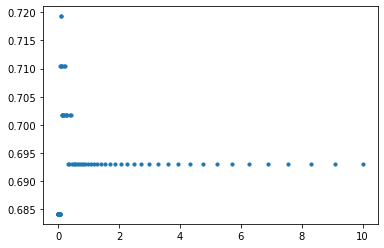

In [681]:
plt.scatter(c_range, accuracy_list, s = 10)
plt.show()

In [682]:
best_accuracy = max(accuracy_list)
best_accuracy_index = accuracy_list.index(best_accuracy)
best_c = c_range[best_accuracy_index]

In [683]:
print('Best Accuracy: ', best_accuracy)
print('Best regularization value', best_c)

Best Accuracy:  0.7192982456140351
Best regularization value 0.08697490026177834


# Logistic Regression

In [684]:
feature_train_dump, feature_test, label_train_dump, label_test = train_test_split(og_feature_train, og_label_train, test_size=0.1)

In [685]:
# Hyperparameter is the number of regularization strength (C), l2 by default
model = LogisticRegression(solver='liblinear', C=best_c, random_state=0)

# Learn the model over the training data
model.fit(feature_train, label_train.values.ravel())

# Predict labels over the testing data
model.predict(feature_test)

# Evaluate accuracy over the testing data
accuracy = model.score(feature_test, label_test)

In [686]:
print(accuracy)

0.7864077669902912


# Interpret Results

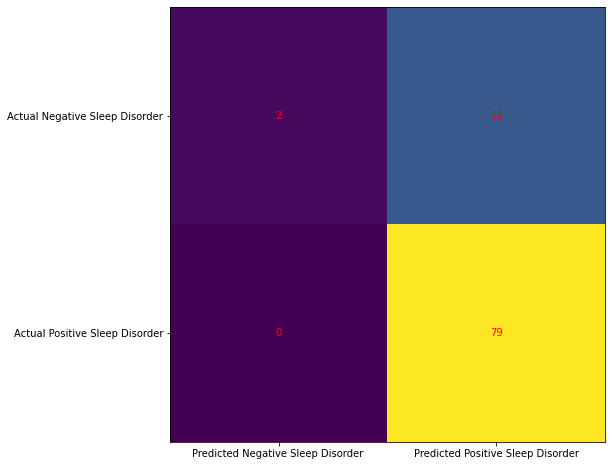

In [687]:
cm = confusion_matrix(label_test, model.predict(feature_test))

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted Negative Sleep Disorder ', 'Predicted Positive Sleep Disorder'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual Negative Sleep Disorder', 'Actual Positive Sleep Disorder'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

In [688]:
print(classification_report(label_test, model.predict(feature_test)))

              precision    recall  f1-score   support

         0.0       1.00      0.08      0.15        24
         1.0       0.78      1.00      0.88        79

    accuracy                           0.79       103
   macro avg       0.89      0.54      0.52       103
weighted avg       0.83      0.79      0.71       103



# Driver (to run entire experiment over k iterations, if needed)

In [689]:
avg_acc = []
for i in range (50) :
    feature_train_dump, feature_test, label_train_dump, label_test = train_test_split(og_feature_train, og_label_train, test_size=0.1)

    # Hyperparameter is the number of regularization strength (C), l2 by default
    model = LogisticRegression(solver='liblinear', C=best_c, random_state=0)

    # Learn the model over the training data
    model.fit(feature_train, label_train.values.ravel())

    # Predict labels over the testing data
    model.predict(feature_test)

    # Evaluate accuracy over the testing data
    avg_acc.append(model.score(feature_test, label_test))

In [690]:
print(mean(avg_acc))

0.7209708737864078
